# RSI model-03
https://chatgpt.com/c/67fd3545-2638-800a-9249-c3fd31a9a198

This model is designed to predict trend reversal points, not based on price predictions. In other words, the model is based on classification, not regression, and future prices are not accurate.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime


In [ ]:
# Load full training data
df = pd.read_csv("../datasets/XAGUSD-H1-rates.csv", sep=r'\s+', engine='python')
df.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TickVol', 'Vol', 'Spread']

# Convert to datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.sort_values('Datetime')
df.reset_index(drop=True, inplace=True)

# Use RSIIndicator from ta
rsi = RSIIndicator(close=df['Close'], window=14)
df['RSI'] = rsi.rsi()

# Drop NaN rows from RSI calculation
df.dropna(inplace=True)

In [ ]:
# Labeling reversal (RSI 30/70)
def label_reversal_targets(data, future_window=5):
    labels = []
    for i in range(len(data) - future_window):
        rsi_now = data.iloc[i]['RSI']
        rsi_future = data.iloc[i + 1:i + future_window + 1]['RSI']

        if rsi_now < 30 and any(r > 35 for r in rsi_future):
            labels.append(1)  # Bullish reversal
        elif rsi_now > 70 and any(r < 65 for r in rsi_future):
            labels.append(1)  # Bearish reversal
        else:
            labels.append(0)
    return np.array(labels)


labels = label_reversal_targets(df)


In [ ]:
# Prepare input windows
SEQ_LEN = 30
features = ['Open', 'High', 'Low', 'Close', 'RSI']

X = []
for i in range(len(df) - SEQ_LEN - 5):  # 5 for future reversal window
    window = df.iloc[i:i + SEQ_LEN][features].values
    X.append(window)

X = np.array(X)
y = labels[:len(X)]

print("X shape:", X.shape)
print("y shape:", y.shape)


In [ ]:
# Train/Test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# LSTM model
from tensorflow.keras.utils import to_categorical

# Don't one-hot encode labels if you use sparse_categorical_crossentropy
# y = to_categorical(y) ← not needed here

model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, len(features))),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])

model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_val, y_val))


In [ ]:
# Load last 30 real candles
df_input = pd.read_csv("../datasets/new-data-for-test/rows-30-from-20240503.csv", sep=r'\s+', engine='python')
df_input.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TickVol', 'Vol', 'Spread']
df_input['Datetime'] = pd.to_datetime(df_input['Date'] + ' ' + df_input['Time'])
df_input = df_input.sort_values('Datetime')
df_input.reset_index(drop=True, inplace=True)

In [ ]:
# Calculate RSI
rsi_input = RSIIndicator(close=df_input['Close'], window=14)
df_input['RSI'] = rsi_input.rsi()
df_input.dropna(inplace=True)

In [ ]:
# Get last 30 real candles (already cleaned)
base_sample = df_input[['Open', 'High', 'Low', 'Close', 'RSI']].values[-30:]
input_sample = base_sample.copy()

future_preds = []
future_rsi = []
future_candles = []

In [ ]:
# Start from last known timestamp
last_time = df_input['Datetime'].iloc[-1]

In [ ]:
# Simple placeholder logic to create dummy candles for future
for step in range(100):
    sample_input = np.expand_dims(input_sample, axis=0)  # shape (1, 30, 5)

    # Predict
    pred = model.predict(sample_input, verbose=0)
    pred_class = np.argmax(pred[0])
    future_preds.append(pred_class)

    # Simulate a dummy next candle: flat close or linear increase
    last_candle = input_sample[-1]
    next_open = last_candle[3]
    next_close = next_open + np.random.normal(0, 0.01)  # tiny movement
    next_high = max(next_open, next_close) + 0.01
    next_low = min(next_open, next_close) - 0.01
    next_rsi = last_candle[4] + np.random.normal(0, 0.5)

    dummy_candle = [next_open, next_high, next_low, next_close, next_rsi]
    input_sample = np.vstack([input_sample[1:], dummy_candle])  # slide window

    future_candles.append(dummy_candle)
    future_rsi.append(next_rsi)

In [ ]:
# Prepare full chart: 30 real + 100 dummy candles
real_part = df_input[['Datetime', 'Open', 'High', 'Low', 'Close', 'RSI']].copy()
future_dates = [last_time + datetime.timedelta(hours=i + 1) for i in range(100)]
future_df = pd.DataFrame(future_candles, columns=['Open', 'High', 'Low', 'Close', 'RSI'])
future_df['Datetime'] = future_dates
future_df['Reversal'] = future_preds

In [ ]:
# Combine
combined_df = pd.concat([real_part, future_df], ignore_index=True)
combined_df.reset_index(drop=True, inplace=True)

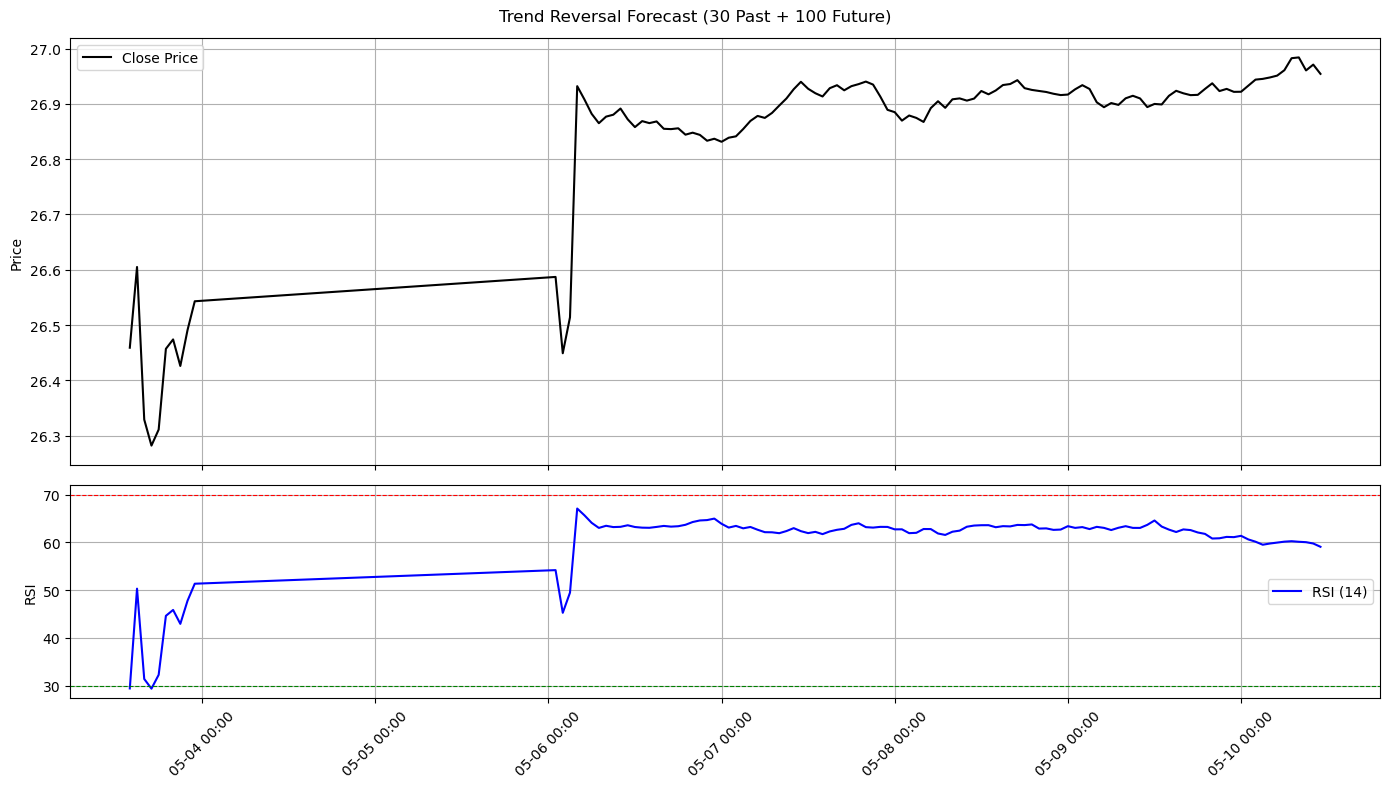

In [37]:
# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle("Trend Reversal Forecast (30 Past + 100 Future)")

# Candlestick line (using close price for simplicity)
ax1.plot(combined_df['Datetime'], combined_df['Close'], label='Close Price', color='black')

# Mark predicted reversals
for idx in range(30, len(combined_df)):  # only future candles
    if combined_df.loc[idx, 'Reversal'] == 1:
        ax1.axvline(x=combined_df.loc[idx, 'Datetime'], color='red', linestyle='--', alpha=0.5)

ax1.set_ylabel("Price")
ax1.legend()
ax1.grid(True)

# RSI Chart
ax2.plot(combined_df['Datetime'], combined_df['RSI'], label='RSI (14)', color='blue')
ax2.axhline(30, color='green', linestyle='--', linewidth=0.8)
ax2.axhline(70, color='red', linestyle='--', linewidth=0.8)
ax2.set_ylabel("RSI")
ax2.legend()
ax2.grid(True)

# Date formatting
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
